In [119]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [120]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [122]:
# seed para reprodutibilidade
np.random.seed(342016)

## Redes neurais

### CNN (Sequential)

In [123]:
dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

In [124]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 3s 928us/step - loss: 47.1235
Epoch 2/30
2500/2500 [==============================] - 2s 936us/step - loss: 1.9203
Epoch 3/30
2500/2500 [==============================] - 2s 882us/step - loss: 0.5328
Epoch 4/30
2500/2500 [==============================] - 2s 881us/step - loss: 0.2554
Epoch 5/30
2500/2500 [==============================] - 2s 933us/step - loss: 0.1472
Epoch 6/30
2500/2500 [==============================] - 2s 948us/step - loss: 0.0896
Epoch 7/30
2500/2500 [==============================] - 2s 932us/step - loss: 0.0620
Epoch 8/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0446
Epoch 9/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0351
Epoch 10/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0292
Epoch 11/30
2500/2500 [==============================] - 2s 966us/step - loss: 0.0245
Epoch 12/30
2500/2500 [==============================] - 2s 971us/st

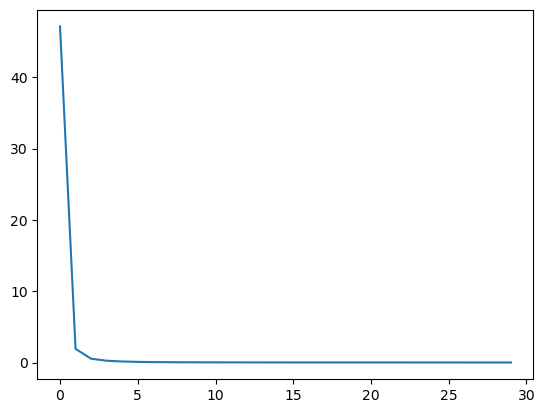

In [125]:
# plot loss history
plt.plot(History.history['loss'])

In [126]:
print(t[:-1].shape)

(800,)


Melhor do que tentar prever próximos estados destas trajetórias existentes, vamos tentar prever o comportamento de duas trajetórias completamente novas (mas integrantes ao sistema para qual a rede foi treinada).

In [127]:
# 2 trajetórias
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

1/1 [==============================] - 0s 15ms/step


In [128]:
ynn.shape

(2, 801, 3)

In [129]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(lorenz_deriv, ynn[1, 0, :], t)
y_t_1

array([[ 4.72297734,  9.97949775, 12.22511434],
       [ 5.25552904, 10.6588341 , 12.41155582],
       [ 5.80523182, 11.40311677, 12.68704748],
       ...,
       [-3.73892692, -4.66418307, 19.29354674],
       [-3.84076481, -4.95225963, 18.96559478],
       [-3.96124421, -5.25952431, 18.66300645]])

In [130]:
y_t_2

array([[-14.00846108,  -8.41626234,   2.62607521],
       [-13.63900285, -11.72992551,   3.93136858],
       [-13.60601553, -14.75998278,   5.60882133],
       ...,
       [  6.05668798,   7.56035759,  21.4724607 ],
       [  6.215466  ,   7.88675643,  21.37502976],
       [  6.39081652,   8.22583387,  21.31360589]])

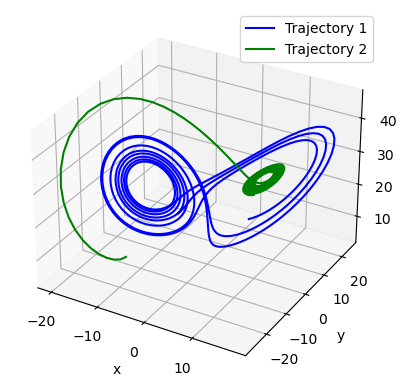

In [131]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2'])
plt.show()

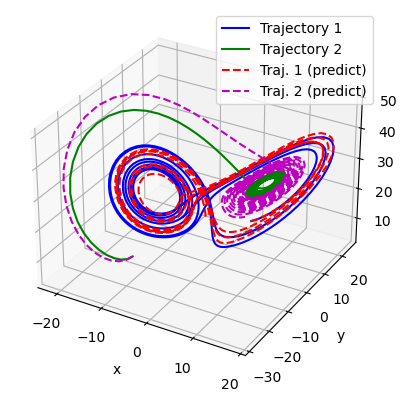

In [132]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
# ynn = np.zeros((num_traj, len(t), 3))
ynn_1 = ynn[0, :, :]
ynn_2 = ynn[1, :, :]
# plot ynn_1 (red, dotted line)
ax.plot(ynn_1[:, 0], ynn_1[:, 1], ynn_1[:, 2], 'r--')
# plot ynn_2 (pink, dotted line)
ax.plot(ynn_2[:, 0], ynn_2[:, 1], ynn_2[:, 2], 'm--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2', 'Traj. 1 (predict)', 'Traj. 2 (predict)'])
plt.show()

In [133]:
# TODO: comentar melhor
# TODO: LSTM

### RNN (LSTM)

TODO

## Métodos numéricos

### SINDy

TODO